# Описание проекта

Просмотр фильмов на оригинальном языке - это популярный и действенный метод прокачаться при изучении иностранных языков. Важно выбрать фильм, который подходит студенту по уровню сложности, т.е. студент понимал 50-70 % диалогов. Чтобы выполнить это условие, преподаватель должен посмотреть фильм и решить, какому уровню он соответствует. Однако это требует больших временных затрат.

Наша задача заключается в разработке ML решения для автоматического определения уровня сложности англоязычных фильмов.

## 1. Общая информация

Здесь будут все необходимые импорты

In [1]:
import os
import re
import nltk
import pysrt

import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler

## 2. Предобработка данных

Откроем файл excel, который содержит названия фильмов и оценку их уровня сложности.

In [2]:
labels = pd.read_excel('English_level/English_scores/movies_labels.xlsx').drop('id', axis=1)
labels

,Movie,Level
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+
...,...,...
236,Matilda(2022),C1
237,Bullet train,B1
238,Thor: love and thunder,B2
239,Lightyear,B2


Откроем папку, в которой лежат субтитры, и созданим из них датафрейм из двух колонок - название фильма и текст субтитров.

In [3]:
basepath = f'English_level/English_scores/Subtitles_all/'
subtitles, movies = [], []

for dirpath, dirnames, filenames in os.walk(basepath):
    for filename in filenames:
        if filename.endswith('.srt'):
            filepath = os.path.join(dirpath, filename)
            movies.append(filename[:-4])
            
            subs = pysrt.open(filepath, encoding='iso-8859-1')
            subs = [sub.text for sub in subs]
            subtitles.append(' '.join(subs))

In [4]:
df = pd.DataFrame({'Movie': movies, 'Subs': subtitles})
df

,Movie,Subs
0,The Walking Dead-S01E01-Days Gone Bye.English,( bugs chittering ) ( brakes squeak ) - ( engi...
1,The Walking Dead-S01E02-Guts.English,- ( birds chirping )\n- ( bugs chittering ) Bo...
2,The Walking Dead-S01E03-Tell It To The Frogs.E...,( thunder rumbling ) Merle:\nThat's right. You...
3,The Walking Dead-S01E04-Vatos.English,( birds chirping ) - What?\n- Nothing. It's no...
4,The Walking Dead-S01E05-Wildfire.English,"- ( walkie-talkie squawks )\n- Rick: Morgan, I..."
...,...,...
273,Warm_bodies(2013),<i>What am I doing</i>\n<i>with my life?</i> <...
274,We_are_the_Millers(2013),"<i>Oh, my God...</i> <i>...it's full-on double..."
275,Westworld_scenes_of_Dr_Robert_Ford,[Music] no one's complained [Music] there's th...
276,While_You_Were_Sleeping(1995),"LUCY: <i>Okay, there are two things that</i>\n..."


Объединим полученную таблицу с экселевской по названиям фильмов.

In [5]:
df = df.merge(labels, on='Movie', how='left')
df

,Movie,Subs,Level
0,The Walking Dead-S01E01-Days Gone Bye.English,( bugs chittering ) ( brakes squeak ) - ( engi...,A2
1,The Walking Dead-S01E02-Guts.English,- ( birds chirping )\n- ( bugs chittering ) Bo...,A2
2,The Walking Dead-S01E03-Tell It To The Frogs.E...,( thunder rumbling ) Merle:\nThat's right. You...,A2
3,The Walking Dead-S01E04-Vatos.English,( birds chirping ) - What?\n- Nothing. It's no...,A2
4,The Walking Dead-S01E05-Wildfire.English,"- ( walkie-talkie squawks )\n- Rick: Morgan, I...",A2
...,...,...,...
277,Warm_bodies(2013),<i>What am I doing</i>\n<i>with my life?</i> <...,B1
278,We_are_the_Millers(2013),"<i>Oh, my God...</i> <i>...it's full-on double...",B1
279,Westworld_scenes_of_Dr_Robert_Ford,[Music] no one's complained [Music] there's th...,NaN
280,While_You_Were_Sleeping(1995),"LUCY: <i>Okay, there are two things that</i>\n...",B1


У нас получился датафрейм из 282 строк, который содержит названия фильмов, тексты субтитров к ним и оценку уровня сложности языка в фильме. Уберем из него дубликаты и пропуски.

In [6]:
df.duplicated().sum()

2

In [7]:
df = df.drop_duplicates()

In [8]:
df.isna().sum()

Movie     0
Subs      0
Level    49
dtype: int64

In [9]:
df = df.dropna()

Приведем оценки, включающие в себя несколько значений, к одному значению.

In [10]:
df['Level'].unique()

array(['A2', 'B1', 'B2', 'C1', 'A2/A2+', 'B1, B2', 'A2/A2+, B1'],
      dtype=object)

In [11]:
df['Level'] = df['Level'].replace('B1, B2', 'B2')
df['Level'] = df['Level'].replace('A2/A2+', 'A2')
df['Level'] = df['Level'].replace('A2/A2+, B1', 'B1')

Посчитаем количество фильмов по категориям. Есть заметный дисбаланс в пользу фильмов категории B.

In [12]:
df['Level'].value_counts()

B2    105
B1     56
C1     39
A2     31
Name: Level, dtype: int64

Перемешаем данные и сбросим индекс.

In [13]:
np.random.seed(0)
df.reindex(np.random.permutation(df.index))

,Movie,Subs,Level
267,The_terminal(2004),"<font color=""#D900D9"">(AIRPLANE APPROACHES)</f...",B1
186,Catch_me_if_you_can(2002),Thank you very much\nand welcome to To Tell th...,B2
217,Lion(2016),"Saroo. Saroo! Come on, come on! Get up! Come o...",B2
233,Pirates_of_the_Caribbean(2003),"<i>Drink up, me hearties, yo ho</i> <i>We kidn...",B1
176,Before_sunrise(1995),<b>Resync By<br/>Lututkanan@subscene</b> Do yo...,B2
...,...,...,...
94,Suits.S01E08.1080p.BluRay.AAC5.1.x265-DTG.02.EN,"Lucille. Hey! Hey, it's looking good. Tell me ...",B2
240,Ready_or_not(2019),"Alex, this way! Come on! Hurry. Get in and don...",A2
157,Suits.S03E05.480p.HDTV.x264-mSD,"I'm looking at a bribe,\nplain as day. That's ...",C1
74,Suits.Episode 12- Live to Fight,". - Mike Ross is a fraud,\nand I'm gonna make ...",B2


In [14]:
df.reset_index(drop=True, inplace=True)

## 3. Предобработка текстовых данных

### 3.1 Работа с текстом

Разделим данные на признаки X и целевой признак y.

In [15]:
X, y = df['Subs'], df['Level']

Текст может содержать цифры, специальные символы и ненужные пробелы, которые будут мешать при обучении модели. Их можно удалить.

In [16]:
stemmer = WordNetLemmatizer()

In [17]:
def preprocessing(text):
    # удаление специальных символов
    document = re.sub(r'\W', ' ', str(text))
    # удаление всех одиноко стоящих символов
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    # удаление всех единичных символов вначале текста
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)
    # замена множественных пробелов одним
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    # удаление приставки b
    document = re.sub(r'^b\s+', '', document)
    # приведение текста к нижнему регистру
    document = document.lower()
    # лемматизация
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    return document

In [18]:
X = X.apply(preprocessing)

### 3.2 Преобразование текста в числа

Для того, чтобы применить методы машинного обучения, нам необходимо преобразовать текст в числа. Для этого воспользуемся методом мешка слов.

Передадим классу CountVectorizer следующие параметры:
- max_features = 500 - означает, что мы будем использовать только 500 наиболее часто встречающихся слов
- min_df = 10 - мы будем использовать только те слова, которые встречаются в минимум 10 документах
- max_df = 0.7 - аналогично, максимальное значение частоты - 70%

Также используем параметр stopwords, который удалит слова, не содержащие полезной информации.

In [19]:
vectorizer = CountVectorizer(max_features=500, min_df=10, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(X).toarray()

Для того, чтобы учесть также частоту встречаемости слова в тексте, воспользуемся методом TF-IDF.

In [20]:
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [21]:
X

array([[0.        , 0.        , 0.03600033, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.04534674, 0.02480932, ..., 0.        , 0.        ,
        0.01474087],
       [0.01016536, 0.        , 0.01327579, ..., 0.00543367, 0.        ,
        0.00438224],
       [0.        , 0.02792823, 0.07334211, ..., 0.04502747, 0.        ,
        0.02420969]])

## 4. Обучение модели

Разделим данные на обучающую и тестовую выборки в пропорции 75/25.

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12345)

Рассмотрим две модели классификации - дерева решений и случайного леса. Для оценки качества модели возьмем метрику accuracy.

In [23]:
DTC_model = None
DTC_result = 0

for depth in range(1, 10):
    for leaf in range(1, 10):
        model = DecisionTreeClassifier(random_state=12345, min_samples_leaf=leaf, max_depth=depth)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        result = accuracy_score(y_test, predictions)
    
        if result > DTC_result:
            DTC_model = model
            DTC_result = result

In [24]:
DTC_result

0.6724137931034483

In [25]:
DTC_model

DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, random_state=12345)

In [26]:
RFC_model = None
RFC_result = 0

for est in range(1, 10):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        result = accuracy_score(y_test, predictions)

        if result > RFC_result:
            RFC_model = model
            RFC_result = result

In [27]:
RFC_result

0.7241379310344828

In [28]:
RFC_model

RandomForestClassifier(max_depth=5, n_estimators=9, random_state=12345)

Модель случайного леса показала лучший результат - 0.724. Но как видно из матрицы ошибок, модель часто ошибается в предсказаниях редких значени (A2 и С1 в нашем случае). Это следствие выявленного ранее дисбаланса в данных.

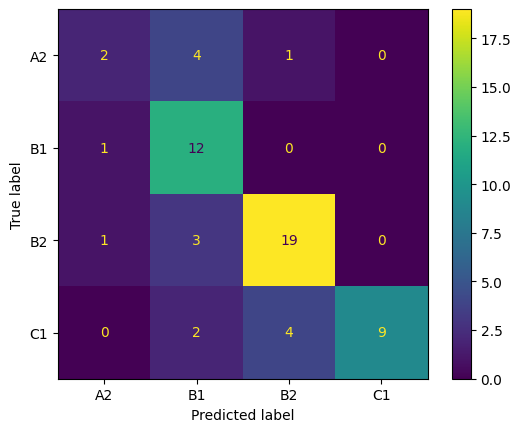

In [29]:
matrix = confusion_matrix(y_test, RFC_model.predict(X_test))
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=RFC_model.classes_)
display.plot()

Попробуем исправить этот дисбаланс увеличением выборки методом RandomOverSampler.

In [30]:
ros = RandomOverSampler()
X_ros, y_ros = ros.fit_resample(X, y)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_ros, y_ros, test_size=0.25, random_state=12345)

In [32]:
RFC_model = None
RFC_result = 0

for est in range(1, 10):
    for depth in range(1, 10):
        model = RandomForestClassifier(random_state=12345, max_depth=depth, n_estimators=est)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        result = accuracy_score(y_test, predictions)

        if result > RFC_result:
            RFC_model = model
            RFC_result = result

In [33]:
RFC_result

0.8476190476190476

Нам удалось заметно улучить результат модели и поднять его до значения 0.848.

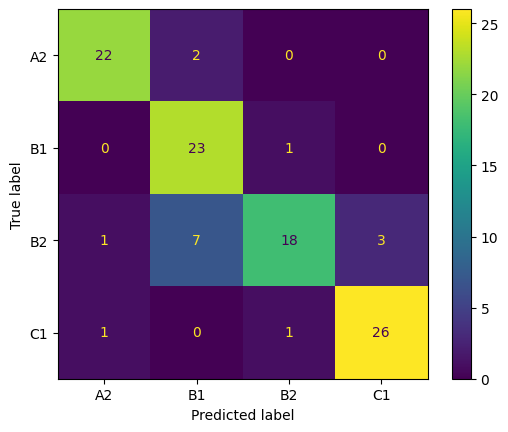

In [34]:
matrix = confusion_matrix(y_test, RFC_model.predict(X_test))
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=RFC_model.classes_)
display.plot()

## 5. Вывод

Перед нами стояла задача разработки ML решения для автоматического определения уровня сложности англоязычных фильмов. Для этого мы воспользовались базой уже размеченных по уровню сложности фильмов. Мы обработали текстовые данные, перевели их в числовой формат. В ходе обучения была выбрана модель случайного леса, которая показала точность 0.72. За счет работы с дисбалансом классов нам удалось повысить этот результат до 0.85.